# Final Support Vector Regression Model

# Imports

In [1]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn import metrics
import itertools
import datetime
from sklearn.preprocessing import MinMaxScaler

### Reading in the soil moisture data and the reservoir data.
We min-max scale reservoir and soil moisture (in a separate dataframe) between 0-1, making it easier to plot the two together.

In [2]:
new_soil = pd.read_csv('south_central_moisture_data_1988_2017.csv')
new_soil.head()

,final_date,soil_moisture,pdsi
0,1988-03-01,4.79,0.0
1,1988-03-08,4.67,0.0
2,1988-03-15,4.24,0.0
3,1988-03-22,5.59,0.0
4,1988-03-29,5.00,0.0


### Choosing only the `final_date` and `soil_moisture` columns.

In [3]:
new_soil = new_soil[['final_date', 'soil_moisture']]

### Changing the type of the `final_date` column to a datetime type. 
We then set the dates to be the index.

In [4]:
new_soil.final_date = pd.to_datetime(new_soil.final_date)
new_soil = new_soil.set_index('final_date')

### Resampling the soil moisture data
This makes our data one-dimensional, which will be necessary later on.

In [5]:
new_soil_agg = new_soil.soil_moisture.resample('W').agg('mean')

### We select a date range starting at 1997-08-10.
Reservoir level data starts at that date, so we can only look at soil moisture data starting at that date. Also worth noting is that the soil moisture data only goes up to 2018-03-04.

In [6]:
new_soil_agg = new_soil_agg['1997-08-10':]

new_soil_agg.head()

final_date
1997-08-10    2.54
1997-08-17    2.02
1997-08-24    1.65
1997-08-31    1.37
1997-09-07    1.19
Freq: W-SUN, Name: soil_moisture, dtype: float64

### Splitting into train, validate, and test data sets.
We want to perform cross validation to find the best hyperparameters for the SVR model, therefore we choose to split the whole data set into three equally sized data sets. Below, we are finding those split points.

In [7]:
split_point_test = round(new_soil_agg.shape[0] * .66)
print(f'For the test set, we will want to split at this index: {split_point_test}')

split_point_train_validate = round(split_point_test/2)
print(f'For the train and validate set, we will want to split at this index: {split_point_train_validate}')

For the test set, we will want to split at this index: 709
For the train and validate set, we will want to split at this index: 354


### Our model will need the input data to be in the form of an array.
We are actually doing the splitting here by indexing certain parts of the data set, and then putting that into an array.

In [8]:
train = np.array(new_soil_agg[:split_point_train_validate])
validate = np.array(new_soil_agg[split_point_train_validate:split_point_test])
test = np.array(new_soil_agg[split_point_test:])

### We have some null values.
This is simply backfilling the nulls with the next value.

In [9]:
train = np.array(pd.Series(train).bfill())
validate = np.array(pd.Series(validate).bfill())
test = np.array(pd.Series(test).bfill())

### Checking the results of the splits.
These print outs are telling us how many years and rows are in each data set. They should be about the same.

In [10]:
print(f'Number of years in train: {round(train.shape[0]/52)}')
print(f'Number of years in validate: {round(validate.shape[0]/52)}')
print(f'Number of years in test: {round(test.shape[0]/52)}')

Number of years in train: 7
Number of years in validate: 7
Number of years in test: 7


In [11]:
print(f'Number of rows in train set: {train.shape[0]}')
print(f'Number of rows in validate set: {validate.shape[0]}')
print(f'Number of rows in test set: {test.shape[0]}')

Number of rows in train set: 354
Number of rows in validate set: 355
Number of rows in test set: 365


### Visualizing the splits.

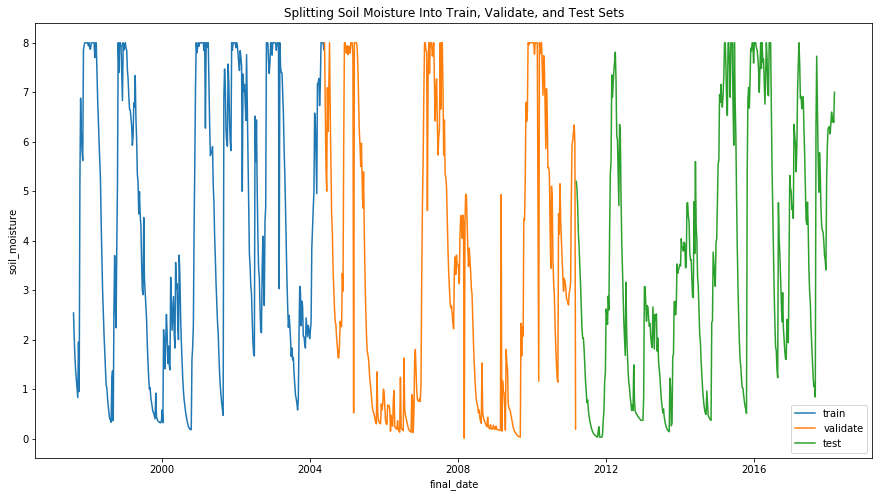

In [12]:
plt.figure(figsize=(15, 8))
sns.lineplot(new_soil_agg.reset_index().final_date,
             new_soil_agg.reset_index().soil_moisture[:split_point_train_validate],
             label='train')
sns.lineplot(new_soil_agg.reset_index().final_date,
             new_soil_agg.reset_index().soil_moisture[split_point_train_validate:split_point_test],
             label='validate')
sns.lineplot(new_soil_agg.reset_index().final_date,
             new_soil_agg.reset_index().soil_moisture[split_point_test:],
             label='test')
plt.title('Splitting Soil Moisture Into Train, Validate, and Test Sets')
plt.show()

### This function allows us to format the data in a way that we can input into the SVR model.
It will take in a numpy array, window size, and step length. It then returns two numpy arrays, one for x values and one for y values.

In [13]:
def embed_data(x, window_size, steps_away):
    n = len(x)
    # steps = n - steps_away
    # print(f'n: {n}')
    xout = np.zeros((n-window_size-steps_away, window_size))
    # print(f'xout: {xout}')
    # print(f'shape of xout: {xout.shape}')
    yout = x[(window_size + steps_away):]
    # print(f'yout: {yout}')
    # print(f'shape of yout: {yout.shape}')
    if steps_away == 0:
        for i in np.arange(window_size, n):
            xout[i-window_size] = x[i-window_size:i]
        # print(f'xout: {xout}')
        return xout, yout
    else:
        for i in np.arange(window_size, n-steps_away):
            xout[i-window_size] = x[i-window_size:i]
        # print(f'xout: {xout}')
        return xout, yout

### Cross-validation for SVR hyperparameters.
With SVR, there is a `window` and a `step`. The window, in our case, is the number of weeks the model will look at when calculating a future prediction. The step is how many weeks into the past the window will be from the most recent value. 

We also want to try to figure out the best combination for the `C` and `gamma` hyperparameters. For those, we try values in a large range but the specific values we are trying increase exponentially.

In [14]:
# windows_to_try = [2, 3, 4, 8, 12, 24, 52] # number of weeks to include in our window
# steps_to_try = [2, 4, 8, 12, 24, 52, 104, 156] # number of weeks to predict in advance
# c_to_try = [2**-15, 2**-10, 2**-5, 2**0, 2**5, 2**10, 2**12, 2**15]
# gamma_to_try = [2**-15, 2**-10, 2**-5, 2**0, 2**5, 2**10, 2**12, 2**15]

# average_mse_dict = {}
# validate_mse_dict = {}
# average_r2 = {}
# validate_r2 = {}
# for combo in list(itertools.product(windows_to_try, steps_to_try)):
#     # print(f'Window size: {combo[0]}     Step size: {combo[1]}')
#     xtrain, ytrain = embed_data(train, combo[0], combo[1])
#     xvalidate, yvalidate = embed_data(validate, combo[0], combo[1])
#     for cg_combo in list(itertools.product(c_to_try, gamma_to_try)):
#         # print(f'C: {cg_combo[0]}     Gamma: {cg_combo[1]}')
#         m = svm.SVR(kernel='rbf', C=cg_combo[0], gamma=cg_combo[1])
#         # C is our regularization constant
#         m_fit = m.fit(xtrain, ytrain)
#         # print('Train')
#         y_pred_train = m_fit.predict(xtrain)
#         # mean squared error
#         mse_train = metrics.mean_squared_error(y_pred_train, ytrain)
#         accuracy_train = m_fit.score(xtrain,ytrain)
#         # plt.plot(y_pred, 'b-', ytrain, 'r-')
#         # plt.show()
#         # print('Validate')
#         y_pred_validate = m_fit.predict(xvalidate)
#         # mean squared error
#         mse_validate = metrics.mean_squared_error(y_pred_validate, yvalidate)
#         accuracy_validate = m_fit.score(xvalidate,yvalidate)
#         average_mse_dict[f'step: {combo[1]} window: {combo[0]}  c:{cg_combo[0]}  gamma: {cg_combo[1]}'] = ((mse_train + mse_validate)/2)
#         validate_mse_dict[f'step: {combo[1]}  window: {combo[0]}  c:{cg_combo[0]}  gamma: {cg_combo[1]}'] = mse_validate
#         average_r2[f'step: {combo[1]} window: {combo[0]} c:{cg_combo[0]}  gamma: {cg_combo[1]}'] = ((accuracy_train + accuracy_validate)/2)
#         validate_r2[f'step: {combo[1]}  window: {combo[0]}  c:{cg_combo[0]}  gamma: {cg_combo[1]}'] = accuracy_validate
#         # plt.plot(y_pred, 'b-', ytrain, 'r-')
#         # plt.show()
    
# print(f'The best window-step/hyperparameter combination by average MSE was: {min(average_mse_dict, key=average_mse_dict.get)}')
# print(f"The average MSE for that combo was: {average_mse_dict[f'{min(average_mse_dict, key=average_mse_dict.get)}']}")
# print('\n')
# print(f'The best window-step/hyperparameter combination by just the validation MSE was: {min(validate_mse_dict, key=validate_mse_dict.get)}')
# print(f"The MSE for the validate set for that combo was: {validate_mse_dict[f'{min(validate_mse_dict, key=validate_mse_dict.get)}']}")
# print('\n')
# print(f'The best window-step/hyperparameter combination by just the validation R2 was: {max(validate_r2, key=validate_r2.get)}')
# print(f"The R2 for the validate set for that combo was: {validate_r2[f'{max(validate_r2, key=validate_r2.get)}']}")
# print('\n')
# print(f'The best window-step/hyperparameter combination by average R2 was: {max(average_r2, key=average_r2.get)}')
# print(f"The average R2 for the validate set for that combo was: {average_r2[f'{max(average_r2, key=average_r2.get)}']}")

### Creating the model(s)
Since the results above suggested two different combinations of hyperparameters, we try them both.

##### Step of 2, window size of 24, C of 1024, gamma of 0.0009765625.
This model's MSE increases with each set.

0.8689621706513201
Train MSE: 0.9541359399007697


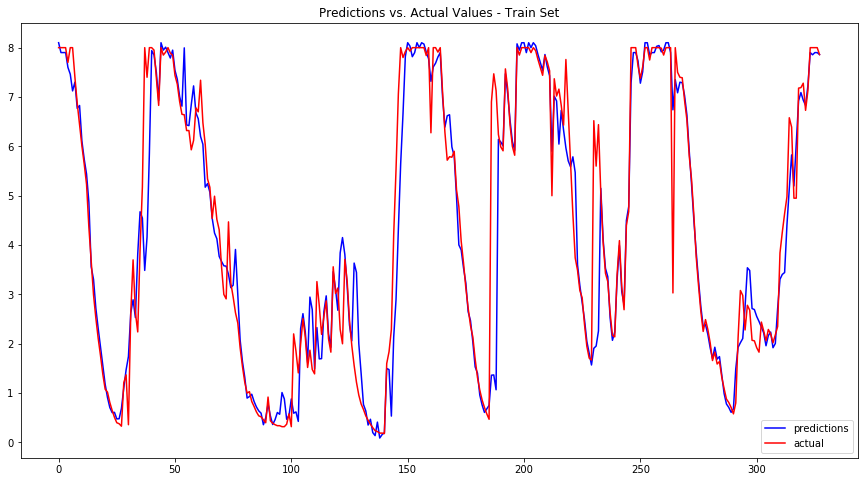

0.6526537869757296
Validate MSE: 2.4636879506070044


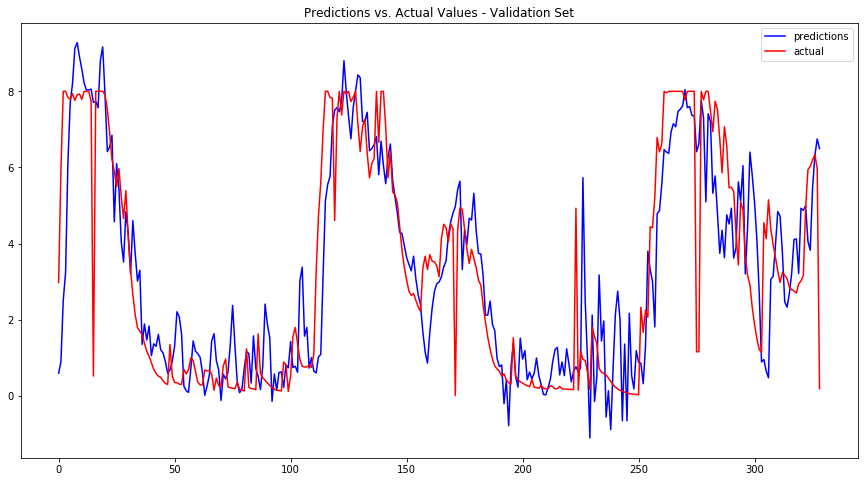

0.6563280574381474
Test MSE: 2.4454786981615677


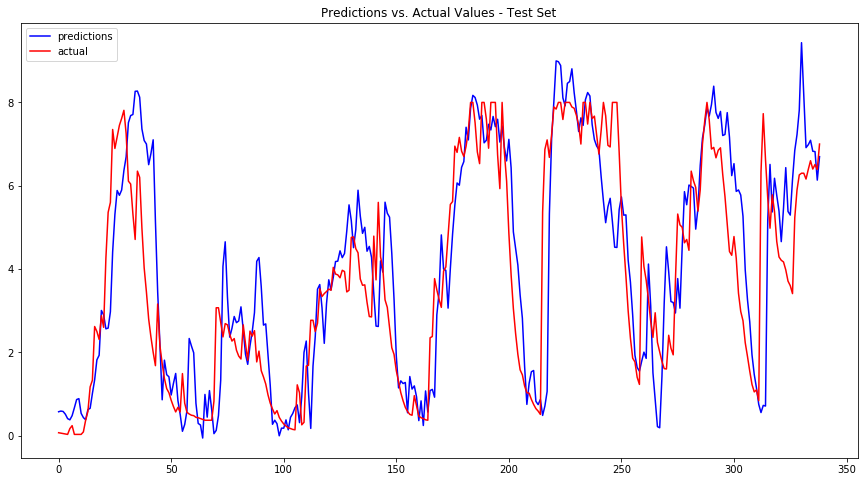

In [15]:
window_size = 24
steps_away = 2
C = 1024
gamma = 0.0009765625
kernel = 'rbf'


xtrain, ytrain = embed_data(train, window_size, steps_away)
xvalidate, yvalidate = embed_data(validate, window_size, steps_away)
xtest, ytest = embed_data(test, window_size, steps_away)
m = svm.SVR(kernel=kernel, C=C, gamma=gamma)
# C is our regularization constant
m_fit = m.fit(xtrain, ytrain)
y_pred = m_fit.predict(xtrain)
# mean squared error
mse = metrics.mean_squared_error(y_pred, ytrain)
print(metrics.r2_score(y_pred, ytrain))
print(f'Train MSE: {mse}')
plt.figure(figsize=(15,8))
plt.plot(y_pred, 'b-', ytrain, 'r-')
plt.legend(('predictions', 'actual', 'PDSI'))
plt.title('Predictions vs. Actual Values - Train Set')
plt.show()

y_pred_validate = m_fit.predict(xvalidate)
mse_validate = metrics.mean_squared_error(y_pred_validate, yvalidate)
print(metrics.r2_score(y_pred_validate, yvalidate))
print(f'Validate MSE: {mse_validate}')
plt.figure(figsize=(15,8))
plt.plot(y_pred_validate, 'b-', yvalidate, 'r-')
plt.legend(('predictions', 'actual', 'PDSI'))
plt.title('Predictions vs. Actual Values - Validation Set')
plt.show()

y_pred_test = m_fit.predict(xtest)
mse_test = metrics.mean_squared_error(y_pred_test, ytest)
print(metrics.r2_score(y_pred_test, ytest))
print(f'Test MSE: {mse_test}')
plt.figure(figsize=(15,8))
plt.plot(y_pred_test, 'b-', ytest, 'r-')
plt.legend(('predictions', 'actual', 'PDSI'))
plt.title('Predictions vs. Actual Values - Test Set')
plt.show()

##### Step of 2, window size of 3, C of 32, gamma of 0.03125.
This model performs well with all three sets. The MSE decreased with the validation set and increased only a little on the test set. Since this model's MSE was lower than the previous model's, this is the model we will use going forward.

r squared: 0.7134360633578749
Train MSE: 2.255361817944978


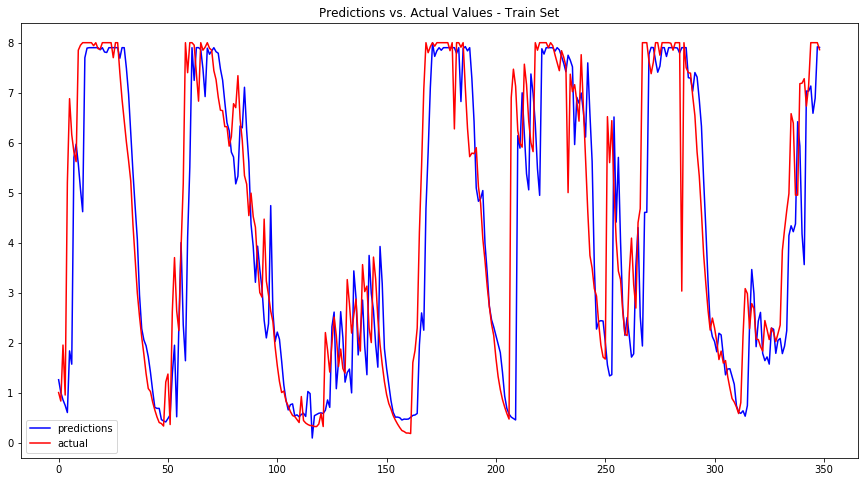

r squared: 0.7229141597281559
Validate MSE: 2.05659162803407


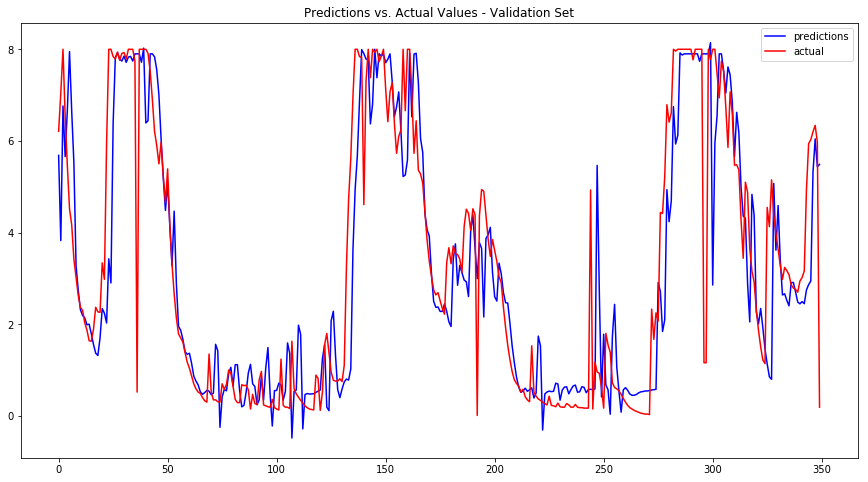

r squared: 0.6962642717770946
Test MSE: 1.9075596998649214


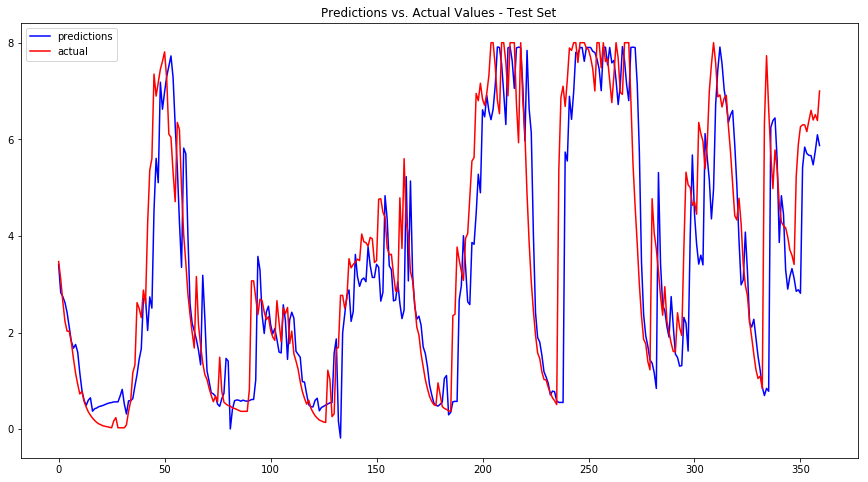

In [30]:
window_size = 3
steps_away = 2
C = 32
gamma = .03125
kernel = 'rbf'


xtrain, ytrain = embed_data(train, window_size, steps_away)
xvalidate, yvalidate = embed_data(validate, window_size, steps_away)
xtest, ytest = embed_data(test, window_size, steps_away)
m = svm.SVR(kernel=kernel, C=C, gamma=gamma)
# C is our regularization constant
m_fit = m.fit(xtrain, ytrain)
y_pred = m_fit.predict(xtrain)
# mean squared error
mse = metrics.mean_squared_error(y_pred, ytrain)
print(f'r squared: {metrics.r2_score(y_pred, ytrain)}')
print(f'Train MSE: {mse}')
plt.figure(figsize=(15,8))
plt.plot(y_pred, 'b-', ytrain, 'r-')
plt.legend(('predictions', 'actual', 'PDSI'))
plt.title('Predictions vs. Actual Values - Train Set')
plt.show()

y_pred_validate = m_fit.predict(xvalidate)
mse_validate = metrics.mean_squared_error(y_pred_validate, yvalidate)
print(f'r squared: {metrics.r2_score(y_pred_validate, yvalidate)}')
print(f'Validate MSE: {mse_validate}')
plt.figure(figsize=(15,8))
plt.plot(y_pred_validate, 'b-', yvalidate, 'r-')
plt.legend(('predictions', 'actual', 'PDSI'))
plt.title('Predictions vs. Actual Values - Validation Set')
plt.show()

y_pred_test = m_fit.predict(xtest)
mse_test = metrics.mean_squared_error(y_pred_test, ytest)
print(f'r squared: {metrics.r2_score(y_pred_test, ytest)}')
print(f'Test MSE: {mse_test}')
plt.figure(figsize=(15,8))
plt.plot(y_pred_test, 'b-', ytest, 'r-')
plt.legend(('predictions', 'actual', 'PDSI'))
plt.title('Predictions vs. Actual Values - Test Set')
plt.show()

### Average r squared

In [29]:
(.6962642717770946 + 0.7229141597281559 + 0.7134360633578749)/3

0.7108714982877085

### Making predictions with our model for unknown soil moisture.
First I want to double check the values in each array and make sure they look correct. It also lets me identify what the input arrays should look like to make the predictions.

In [17]:
ytest[-20:]

array([4.66, 4.29, 4.21, 4.17, 3.98, 3.71, 3.6 , 3.41, 5.23, 5.9 , 6.26,
       6.3 , 6.3 , 6.16, 6.39, 6.6 , 6.4 , 6.51, 6.39, 7.  ])

In [18]:
xtest[-20:]

array([[6.63, 5.7 , 4.98],
       [5.7 , 4.98, 5.78],
       [4.98, 5.78, 5.38],
       [5.78, 5.38, 4.66],
       [5.38, 4.66, 4.29],
       [4.66, 4.29, 4.21],
       [4.29, 4.21, 4.17],
       [4.21, 4.17, 3.98],
       [4.17, 3.98, 3.71],
       [3.98, 3.71, 3.6 ],
       [3.71, 3.6 , 3.41],
       [3.6 , 3.41, 5.23],
       [3.41, 5.23, 5.9 ],
       [5.23, 5.9 , 6.26],
       [5.9 , 6.26, 6.3 ],
       [6.26, 6.3 , 6.3 ],
       [6.3 , 6.3 , 6.16],
       [6.3 , 6.16, 6.39],
       [6.16, 6.39, 6.6 ],
       [6.39, 6.6 , 6.4 ]])

### Making the input array for predictions.

In [19]:
a, b, c, d, e = ytest[-5:]

x_for_pred = np.array(([a , b, c], [b, c, d], [c , d, e]))

### Making the predictions

In [20]:
predictions = m_fit.predict(x_for_pred)
pred_df = pd.DataFrame(predictions)
pred_df['date'] = new_soil_agg.index[-1]

correct_dates = []
i=7
for date in pred_df.date:
    correct_date = date + timedelta(days=(i))
    correct_dates.append(correct_date)
    i += 7
    
pred_df.date = correct_dates    
pred_df.rename(columns={0:'predicted_soil_moisture'}, inplace=True)
pred_df = pred_df[['date', 'predicted_soil_moisture']]
pred_df

,date,predicted_soil_moisture
0,2018-03-11,5.978140
1,2018-03-18,5.836493
2,2018-03-25,6.625114


### Saving the predictions to a csv file.

In [21]:
# pred_df.to_csv('three_week_soil_moisture_predictions.csv', index=False)

### Testing the function for getting an instant prediction.

In [22]:
from predict import get_inputs_and_predict

get_inputs_and_predict('2017')

/Users/MatthewZapata/Main_data_repo/clean_prep_moisture_data.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['date'] = f'{df.year.iloc[0]}-03-01'
/Users/MatthewZapata/Main_data_repo/clean_prep_moisture_data.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['date'] = pd.to_datetime(df['date'])
/Users/MatthewZapata/Main_data_repo/clean_prep_moisture_data.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

(Timestamp('2018-03-18 00:00:00', freq='W-SUN'), 6.625114229849016)